In [1]:
%cd src/
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101, resnet34, resnet18
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time
import timm
import torch



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()
    
#         self.backbone = timm.create_model('ecaresnet101d', pretrained=True,)
#         del self.backbone.fc
        self.backbone = resnet101(pretrained=False)
        del self.backbone.fc
        
        
#         del self.backbone.classifier, self.backbone.conv_head, self.backbone.bn2,self.backbone.act2,self.backbone.global_pool
        _ = self.backbone.to("cpu")
#         for name,p in self.backbone.named_parameters():
#             if "bn" not in name or "attnpool" in name:
#                 p.requires_grad =  FalseFalse

        # create a default PyTorch transformer
        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab
        # DETR used basic 3 layer MLP for output
        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        # Detr baseline uses sine positional encoding.
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask
    
#     def get_feature(self,x):
#             x = self.backbone.conv_stem(x)
#             x = self.backbone.bn1(x)   
#             x = self.backbone.act1(x)
#             x = self.backbone.blocks(x)
#             return x

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x

#     def get_feature(self, x):
#         x = self.backbone.forward_features(x)
#         return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        # Padding mask
        trg_pad_mask = self.make_len_mask(trg)

        # Getting postional encoding for target
        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source, split, transform, tokenizer):
        self.tokenizer = tokenizer
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x.decode() for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
#         img = cv2.transpose(img)
        img = np.repeat(img[..., np.newaxis],3, -1).astype("float32")   
#         img = pp.normalization(img).astype("float32")

        if self.transform is not None:
            aug = self.transform(image=img)
            img = aug['image']
            
#             img = self.transform(img)
            
        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size

class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""
        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")

/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/src


In [3]:
import os
import datetime
import string

batch_size = 16
epochs = 200

# define paths
#change paths accordingly
source = 'iam'
source_path = '../data/{}.hdf5'.format(source)
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam_{}.hdf5".format("dsa"))
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]
# charset_base = string.printable[:36].lower() + string.printable[36+26:95].lower() 

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

import torchvision.transforms as T
local_rank = 0
device = torch.device("cuda:{}".format(local_rank))

# transform = T.Compose([
#     T.ToTensor()])
tokenizer = Tokenizer(charset_base)
import albumentations
import albumentations.pytorch



transform_valid = albumentations.Compose(
    [
        albumentations.Normalize(),
        albumentations.pytorch.ToTensorV2()
    ]
)

source: ../data/iam.hdf5
output ../output/iam
target ../output/iam/checkpoint_weights_iam_dsa.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [4]:
tokenizer = Tokenizer(charset_base)

In [5]:
model = make_model( vocab_len=tokenizer.vocab_size,hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4)

_ = model.to(device)

In [13]:
d = torch.load("/home/mhamdan/seq2seqAttenHTR/Transformer_ocr/output/avid-eon-37/iam_first_110.pt", map_location="cuda:1")

In [14]:
f = {}
for i in d:
    f[i.replace("module.","")] = d[i]

model.load_state_dict(f)

<All keys matched successfully>

In [15]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))
    

def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    c=0
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.to(device), trg.to(device)            
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to(device)
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
#             if c==500:
#                 break
            c+=1
    return predicts, gt, imgs

In [9]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,'test',transform_valid, tokenizer), batch_size=1, shuffle=False, num_workers=6)

In [16]:
predicts, gt, imgs = test(model,test_loader , max_text_length)

In [17]:
predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)

In [12]:
evaluate 

array([0.09312924, 0.26256329, 0.88842105])

In [18]:
evaluate

array([0.08154404, 0.24060894, 0.85263158])

In [21]:
evaluate

array([0.13702334, 0.22861072, 0.68009119])

In [27]:
evaluate

array([0.06837672, 0.16948108, 0.61854103])

In [12]:
more = predicts.copy()

In [18]:
less = predicts.copy()

In [57]:
# less[:3], more[:3]

In [13]:
predicts[:10]

['squite unable to explain why he should feel',
 'meet the Deanes , and as scon as Gny had',
 'the harges and drank grough to cre ow',
 "you not killed ! ' Because we know all things , ' the",
 'with the possibility of fanltty design . " He held',
 'all due deference , Miss beaue - come off it ! " ',
 '3t would have been acceptable to all concemed',
 'to make you understand just what happered',
 'course of action should be . First to avoid the',
 'I Stamp Departmentl ) while sally salked at home . ']

In [25]:
le = 10

In [30]:
more[:2]

['Je vous serais reconnaissante de bien vouloir prendre',
 'cur je dais finourcu mon mariage']

In [26]:
evaluation.ocr_metrics(predicts=less[:le],
                                  ground_truth=gt[:le])

array([0.01645542, 0.06754902, 0.4       ])

In [27]:
evaluation.ocr_metrics(predicts=more[:le],
                                  ground_truth=gt[:le])

array([0.06857834, 0.17412465, 0.5       ])

In [27]:
lless = [v for i,v in enumerate(less) if i not in rem]
gless = [v for i,v in enumerate(gt) if i not in rem]
mmore = [v for i,v in enumerate(more) if i not in rem]

In [28]:
evaluation.ocr_metrics(predicts=lless,
                                  ground_truth=gless),evaluation.ocr_metrics(predicts=mmore,
                                  ground_truth=gless)

(array([0.03315958, 0.08458639, 0.34398496]),
 array([0.05809512, 0.15275311, 0.54135338]))

In [87]:
rem = []
for i,v in enumerate(gt):
    nm = evaluation.ocr_metrics(predicts=[predicts[i]],
                                  ground_truth=[v])    
    print("gt", v)
    print("less", predicts[i], nm)
    print("-"*50)
        

gt ai regle regulierement les interets . 
less ai regle regulierement les interets .  [0. 0. 0.]
--------------------------------------------------
gt le cas echeant pour qu ' une nouvelle ristourne me soit accordee . 
less le cas echerant pour qu ' une nouvelle ristourne un soit accordie .  [0.05882353 0.23076923 1.        ]
--------------------------------------------------
gt concernant votre service de telephonie . Je m ' y suis en effet inscrite il y a
less concernant votre service de telephonie . Je m ' il suis en effet in effet inscitite d l y a [0.16483516 0.3        1.        ]
--------------------------------------------------
gt Je vous prie d ' agreer , Madame , Monsieur , l ' expression de mes
less Je vous prie d ' agreer , Madame , Monsieur , l ' expression de mes [0. 0. 0.]
--------------------------------------------------
gt J ' ai pu relever differents dommages : peinture et moquette abimees et
less J ' ai pu relever differents dommages : perture etur ature noqueture 

less Pourriez - vous me faire parvenir un constat de desait des [0.03448276 0.09090909 1.        ]
--------------------------------------------------
gt documentation detaillee au sujet des differents
less documentation detaillee au sujet des differents [0. 0. 0.]
--------------------------------------------------
gt mes respectueuses salutations . 
less mes respectueuses salutations .  [0. 0. 0.]
--------------------------------------------------
gt s ' ameliore pas et cela m ' occasionne des troubles du
less s ' ametiore pas et cela m ' occasionne des troubles des troubles du [0.20588235 0.21428571 1.        ]
--------------------------------------------------
gt En vous remerciant par avance de votre comprehension , 
less En vous remerciant par avance de votre comprehension ,  [0. 0. 0.]
--------------------------------------------------
gt l ' expression de mes sinceres salutations . 
less l ' expression de mes sinceres salutations .  [0. 0. 0.]
------------------------------------

less a quelles sont les conditions de couscription ?  [0.0625 0.25   1.    ]
--------------------------------------------------
gt En esperant que ce courrier retiendra toute votre attention , 
less En esperant que ce courrier rehiendie toute votre attention ,  [0.0483871 0.1       1.       ]
--------------------------------------------------
gt Veuillez agreer , Madame , Monsieur , l ' expression de mes salutations
less Veuillez agreer , Madame , Monsieur , l ' expression de mes salutations [0. 0. 0.]
--------------------------------------------------
gt Vous remerciant de l ' attention que vous accorderez
less Vous remerciant de l ' attention que vous accorderez [0. 0. 0.]
--------------------------------------------------
gt Je vous adresse ce courrier afin d ' operer une modification de commande . 
less Je vous adresse ce courrier afin d ' aprerer une modification de commande .  [0.02631579 0.07142857 1.        ]
--------------------------------------------------
gt Je trouve anorm

less demande et me faire parvenir par courrier l ' ordre pour [0. 0. 0.]
--------------------------------------------------
gt complementaires . 
less compementaines .  [0.11111111 0.5        1.        ]
--------------------------------------------------
gt Or , de graves difficultes financieres ne me permettent pas
less Or , de graves difficultes financieres ne me permettent pas [0. 0. 0.]
--------------------------------------------------
gt mon portefeuille d ' actions . 
less mon partefeuille d ' actions .  [0.03225806 0.16666667 1.        ]
--------------------------------------------------
gt sommeil . 
less famel .  [0.4 0.5 1. ]
--------------------------------------------------
gt proceder a la resiliation de l ' assurance du dit vehicule a compter
less proceder a la resiliation de l ' assurance du du dit vehit vehicule a compter [0.11688312 0.13333333 1.        ]
--------------------------------------------------
gt Depuis le mois dernier je n ' habite plus dans le logement d

less vous me fournisiez votre documentation en matiere d ' assurance vie .  [0.01408451 0.08333333 1.        ]
--------------------------------------------------
gt du contrat , ne sont absolument pas respectees . C ' est pourquoi je vous demande
less de contrat ne sont absolument pas respectees . C ' est poutipourquiees . C ' est pourqpoctioioi je vous de demande [0.33333333 0.42857143 1.        ]
--------------------------------------------------
gt commande , ainsi qu ' a la suite que vous lui donnerez , je vous
less commande , ainsi qu ' a la suite que vous lui donnerez , je vous [0. 0. 0.]
--------------------------------------------------
gt En vous remerciant vivement , veuillez agreer , 
less En vous remerciant vivement , veuillez agreer ,  [0. 0. 0.]
--------------------------------------------------
gt multiplier par deux la quantite de chausettes que
less multipier par deux la quantite de chaussettes que [0.04081633 0.25       1.        ]
------------------------------------

In [15]:
rem = []
for i,v in enumerate(gt):
    mm = evaluation.ocr_metrics(predicts=[more[i]],
                                  ground_truth=[v])
    nm = evaluation.ocr_metrics(predicts=[predicts[i]],
                                  ground_truth=[v])    
    
    if mm[0]<nm[0]:
        rem.append(i)
        print("gt", v)
        print("more", more[i], mm)
        print("less", predicts[i], nm)
        print("-"*50)
        

gt echeance le montant verse sur mon PEL soit de 45 euros . 
more echeance le montant vense sur mon PEL sait de 45 euros .  [0.03508772 0.16666667 1.        ]
less echeance le montant coernse sur mon PEL soit de 45 euros .  [0.05084746 0.08333333 1.        ]
--------------------------------------------------
gt d ' un lot de cinquante CD vierges ( reference 010 - 25 - CDV ) . 
more d ' un sot de cirquante CD vierges ( reference 000000 - 25 . CDV ) .  [0.10144928 0.23529412 1.        ]
less d ' un lot de cinquante CD vierges ( reference 010 - 25 - CD - CD . CD .  [0.12328767 0.25       1.        ]
--------------------------------------------------
gt changement de situation . J ' ai en effet donne naissance
more changement de situation . J ' ai en effet donne naissance [0. 0. 0.]
less changement de situation . J ' ai en effet donne maissance [0.01754386 0.09090909 1.        ]
--------------------------------------------------
gt Madame , Monsieur , de bien vouloir agreer l ' expression 

less mest distingues .  [0.75 1.   1.  ]
--------------------------------------------------
gt Je me permets de prendre contact avec votre service afin d ' avoir de plus amples
more Je me permet de prendre contac votre servie afin d ' avoir d ' avoir de pus amples [0.23170732 0.44444444 1.        ]
less Je me permet de prendre contact avec votre survice aler d ' avec c votre air ailir de de d d ' d d avoir dir d d ' d d ' avon av [0.484375   0.70588235 1.        ]
--------------------------------------------------
gt nous devons proceder a l ' enregistrement des donnees recoltees . 
more nous devons proceder a l ' enregistrement des derneer recollees .  [0.06060606 0.18181818 1.        ]
less nous devons proceder a l ' enregitrement des donnees recouit res recouit .  [0.17333333 0.30769231 1.        ]
--------------------------------------------------
gt Les degats sont uniquement materiel . 
more Les de sats sont unique ment materiel .  [0.075 0.5   1.   ]
less les desarts sont unique

In [57]:
len("mon conseiller AVE ne propose que des emplois sous que diffies .")

64

In [86]:
len(rem)

239

In [32]:
from PIL import Image, ImageOps
import numpy as np

"""
Creates an augmented image by applying Random warp grid distortion.
This is based on/inspired by
Wigington, Curtis, et al. 
"Data Augmentation for Recognition of Handwritten Words and Lines Using a CNN-LSTM Network." 
Document Analysis and Recognition (ICDAR), 2017 14th IAPR International Conference on. 
Vol. 1. IEEE, 2017.
"""

class GD(object):
    def __init__(self, prob=0.7, gridsize=(26, 26), deviation=1.7):
        self.probability = prob
        self.gridsize = gridsize
        self.deviation = deviation

    def __call__(self, sample):
        image = sample
        if np.random.rand() < self.probability:
            image = _warp(image, self.gridsize, self.deviation)
        return image

def RandomWarpGridDistortion(images, count, gridsize, deviation):
    new_images = []
    for image in images:
        new_images.extend([_warp(image, gridsize, deviation)
                           for i in range(count)])
    images.extend(new_images)
    return images


def _warp(img, gridsize=None, deviation=None, mat=None, return_mat=False):
    gridsize = gridsize or (26, 26)
    deviation = deviation or 10
    (w, h) = img.size

    num_x = w // gridsize[0] + 1
    num_y = h // gridsize[1] + 1

    mat = mat if mat is not None else np.random.normal(
        scale=deviation, size=(num_y + 1, num_x + 1, 2))

    mesh = []
    for x in range(num_x):
        for y in range(num_y):
            target = (x * gridsize[0], y * gridsize[0],
                      (x + 1) * gridsize[0], (y + 1) * gridsize[0])
            nw_y = y * gridsize[0] + mat[y, x, 0]
            nw_x = x * gridsize[0] + mat[y, x, 1]

            sw_y = (y + 1) * gridsize[0] + mat[y + 1, x, 0]
            sw_x = x * gridsize[0] + mat[y + 1, x, 1]

            se_y = (y + 1) * gridsize[0] + mat[y + 1, x + 1, 0]
            se_x = (x + 1) * gridsize[0] + mat[y + 1, x + 1, 1]

            ne_y = y * gridsize[0] + mat[y, x + 1, 0]
            ne_x = (x + 1) * gridsize[0] + mat[y, x + 1, 1]

            source = (nw_x, nw_y, sw_x, sw_y, se_x, se_y, ne_x, ne_y)

            mesh.append((target, source))

    img_transformed = img.transform(
        img.size,
        method=Image.MESH,
        data=mesh,
        fillcolor=255)

    if return_mat:
        return img_transformed, mat
    else:
        return img_transformed

In [13]:
im = Image.open("../raw/iam/lines/b01/b01-000/b01-000-00.png")

In [52]:
im.transpose

<bound method Image.transpose of <PIL.PngImagePlugin.PngImageFile image mode=L size=1620x85 at 0x7F87F3C10B20>>

array([[244, 251, 251, ..., 255, 255, 255],
       [251, 251, 251, ..., 255, 255, 255],
       [251, 251, 250, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [69]:
gg = _warp(Image.fromarray(cv2.transpose(np.array(im))), deviation=2.7)

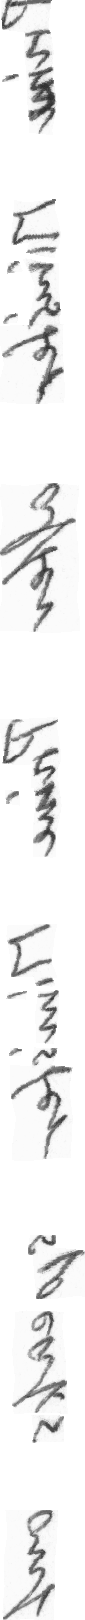

In [70]:
gg

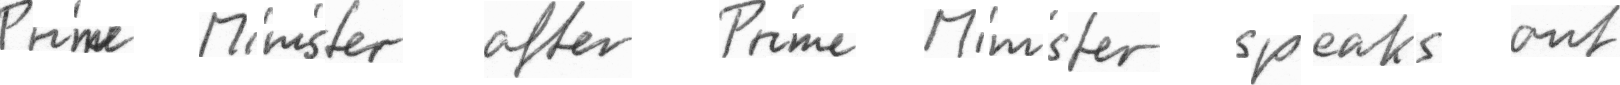

In [38]:
im

In [70]:
img = pp.preprocess("../raw/iam/lines/b01/b01-000/b01-000-00.png", input_size=(1024,128,1))

In [67]:
def pre(path, input_size):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    wt, ht, _ = input_size
    h, w = img.shape
    f = max((w / wt), (h / ht))
    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    img = cv2.resize(img, new_size)
    img = pp.illumination_compensation(img)
    img = pp.remove_cursive_style(img)
    img = cv2.resize(img, new_size)
    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    return target

In [68]:
img = pre("../raw/iam/lines/b01/b01-000/b01-000-00.png", input_size=(1024,128,1))

In [30]:
dataset = {}
with h5py.File("../data/bentham.hdf5", "r") as f:
    dataset["valid"] = dict()

    dataset["valid"]['dt'] = np.array(f["valid"]['dt'])
    dataset["valid"]['gt'] = np.array(f["valid"]['gt'])


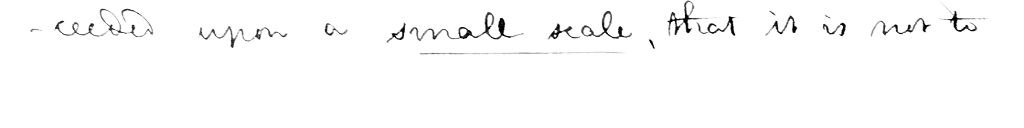

In [39]:
Image.fromarray(cv2.transpose(np.repeat(dataset["valid"]['dt'][35][..., np.newaxis],3, -1) ))

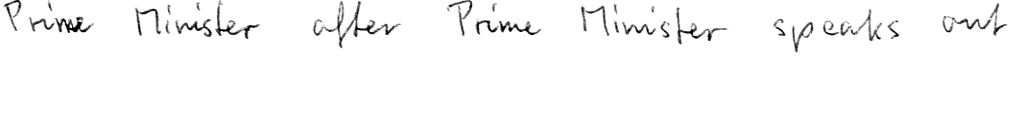

In [73]:
Image.fromarray(cv2.transpose(img))

In [ ]:
cv2.transpose(img)

In [13]:
import json
# with open("pre.json","w") as f:
#     json.dump(less+ more, f)
    
with open("pre.json","r") as f:
    a= json.load(f)

In [77]:
1542//2

771

In [14]:
less = a[:771]

In [14]:
more = a[771:]

In [37]:
source = "../data/rimes.hdf5"
split = "train"

In [38]:
dataset = dict()

with h5py.File(source, "r") as f:
    dataset[split] = dict()

    dataset[split]['dt'] = np.array(f[split]['dt'])
    dataset[split]['gt'] = np.array(f[split]['gt'])

    randomize = np.arange(len(dataset[split]['gt']))
    np.random.seed(42)
    np.random.shuffle(randomize)

    dataset[split]['dt'] = dataset[split]['dt'][randomize]
    dataset[split]['gt'] = dataset[split]['gt'][randomize]

    # decode sentences from byte
    dataset[split]['gt'] = [x.decode() for x in dataset[split]['gt']]


In [41]:
len(dataset[split]['dt'])

10114

In [22]:
from PIL import Image

In [41]:
for i,v in enumerate(dataset[split]['gt']):
    if "ne quantite importante de" in unicodedata.normalize("NFKD", v).encode("ASCII", "ignore").decode("ASCII"):
        print(i)
#     Image.fromarray(cv2.transpose(dataset["test"]["dt"][1]))

761


In [48]:
gt[769], predicts[769]

('le revenu . Je souhaite , a partir de ce jour , opter pour',
 'le revenu . Je souhaite , a partir de ce jour , opter pour')

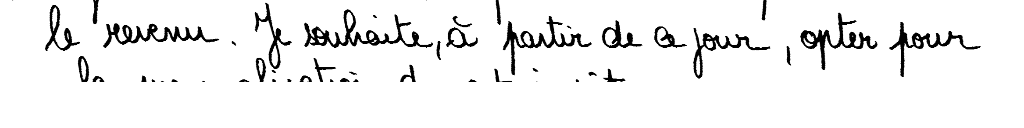

In [46]:
Image.fromarray(cv2.transpose(dataset["test"]["dt"][769]))

In [39]:
tokenizer.encode('ai réglé régulièrement les intérêts .')

array([ 2, 14, 22, 98, 31, 18, 20, 25, 18, 98, 31, 18, 20, 34, 25, 22, 18,
       31, 18, 26, 18, 27, 33, 98, 25, 18, 32, 98, 22, 27, 33, 18, 31, 18,
       33, 32, 98, 79,  3])

In [40]:
tokenizer.decode([ 2, 14, 22, 98, 31, 18, 20, 25, 18, 98, 31, 18, 20, 34, 25, 22, 18,
       31, 18, 26, 18, 27, 33, 98, 25, 18, 32, 98, 22, 27, 33, 18, 31, 18,
       33, 32, 98, 79,  3])

'SOSai regle regulierement les interets . EOS'

In [69]:
img = cv2.imread("../raw/iam/lines/b01/b01-000/b01-000-00.png")

In [70]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [65]:
img.shape, gray.shape

((140, 1856, 3), (140, 1856))

In [58]:
im = pp.preprocess("../raw/iam/lines/a04/a04-000/a04-000-00.png", (1024, 128, 1))

In [71]:
imm = pp.remove_cursive_style(gray)

In [72]:
cv2.imwrite("temp.png",imm)

True

In [54]:
im.shape

(1024, 128)

In [19]:
from torchvision.models import resnet50, resnet34, resnet18

r = resnet18(pretrained=True)

In [23]:
    def get_feature(backbone, x):
        x = backbone.conv1(x)
        x = backbone.bn1(x)   
        x = backbone.relu(x)
        x = backbone.maxpool(x)

        x = backbone.layer1(x)
        x = backbone.layer2(x)
        x = backbone.layer3(x)
        x = backbone.layer4(x)
        return x


In [24]:
a = torch.rand(1,3,1024,128)

In [25]:
get_feature(r,a).shape

torch.Size([1, 512, 32, 4])